# Classification based on n-gram probabilities

## Preparing the training corpus

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk import word_tokenize
from nltk.util import ngrams
from nltk.lm import NgramCounter
from nltk.corpus import stopwords
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context 
nltk.download('stopwords')

np.random.seed(42)

[nltk_data] Downloading package stopwords to /Users/Yura/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# load transcripts
data_path = '../data/processed/'
transcripts_df = pd.read_csv(data_path + 'all_transcripts.csv', sep='\t')
transcripts_df.head()

,file_name,content,meaningful
0,LEL175JU154.json,(xx) could i have your attention please? Dr Ha...,1
1,LEL295JU035.json,let me ask a question. no yeah the font's too ...,1
2,STP560JG118.json,computer to work. um first we'd like to start ...,1
3,OFC105SU068.json,right. here uh the clipboard. that i ga- okay ...,1
4,COL385MU054.json,"this lecture uh, we are very pleased that the ...",1


In [15]:
# selecting a portion of good transcripts for training
good_transcripts = transcripts_df[transcripts_df.meaningful == 1.0]['content']
bad_transcripts  = transcripts_df[transcripts_df.meaningful == 0.0]['content']

n_good  = good_transcripts.shape[0]
n_bad   = bad_transcripts.shape[0]

n_training = n_good - n_bad
training_ind = np.random.choice(range(n_good), size=n_training, replace=False)
testing_ind = [i for i in range(n_bad + n_good) if i not in training_ind]
training_data = good_transcripts[training_ind].values
testing_data = transcripts_df.loc[testing_ind, 'content'].values
testing_labels = transcripts_df.loc[testing_ind, 'meaningful'].values
training_data[0:5]

array(["if everyone's here, um, my name is Dale Jerome, and i'm a volunteer docent, is the word we use here, but it really means tour guide, i i have a question yes you said if the second floor was dedicated to the art  i assume it was alumni offices. uh, it was office space and, i- i don't know, exactly what was in the office space but since it's called Alumni Memorial Hall, oh okay Garden of Eden. okay, the Garden of Eden... now that's more of a, a concept but of course we're looking, at a t- fruit tree here of some sort, um, a figure. this, animal coiled around here and it's all taking place, in a l- in a garden. anything that i've missed? how do we know it's a garden? there's plants. yeah. there are plants. um, anything else i may have missed? the fruit tree? the fruit tree,  the water. the water. if you look way beyond, what is the land here, you'll see that these hues of blue these uh these shades of blue, vary a little bit in the background, and if you look very closely, you'll 

In [16]:
def extract_ngrams(text, n):
    tokens = nltk.word_tokenize(text)
    tokens = [token.lower() for token in tokens]
    grams = ngrams(tokens,n)
    return grams

grams = []
n = 2
for text in training_data:
    grams.append(extract_ngrams(text, n))
gram_counts = NgramCounter(grams)

In [17]:
gram_counts[2].items()

dict_items([(('if',), FreqDist({'you': 1083, 'it': 248, 'i': 233, 'we': 198, 'they': 137, 'the': 95, 'that': 74, ',': 73, 'there': 68, 'if': 65, ...})), (('everyone',), FreqDist({"'s": 15, 'else': 12, ',': 8, 'can': 4, 'knows': 4, 'was': 3, 'to': 3, '(': 3, 'had': 2, 'has': 2, ...})), (("'s",), FreqDist({'a': 979, 'not': 643, 'the': 580, ',': 452, 'just': 278, 'what': 246, 'like': 242, 'gon': 207, 'it': 188, 'that': 155, ...})), (('here',), FreqDist({',': 254, '.': 224, '?': 126, "'s": 119, 'is': 65, 'and': 62, 'you': 47, 'at': 31, 'to': 29, 'in': 27, ...})), ((',',), FreqDist({'and': 2363, 'i': 2010, 'um': 1764, 'the': 1717, 'you': 1536, 'uh': 1241, 'that': 1175, 'it': 1066, 'so': 814, 'but': 710, ...})), (('um',), FreqDist({',': 3392, 'i': 187, '...': 167, 'the': 94, 'and': 91, 'you': 65, 'that': 52, 'so': 49, 'it': 46, 'in': 46, ...})), (('my',), FreqDist({',': 59, 'god': 26, 'name': 22, 'mind': 22, 'own': 18, 'head': 13, 'paper': 12, 'computer': 12, 'gosh': 11, 'question': 11, ...}

In [18]:
def cohesion_score(test_text, gram_counts):
    tokens = nltk.word_tokenize(test_text)
    tokens = [token.lower() for token in tokens]
    l = len(tokens)
    probs = np.empty(l - 1)
    for i in range(l - 1):
        first = tokens[i]
        second = tokens[i+1]
        fdict = gram_counts[[first]]
        if (fdict.N() == 0):
            probs[i]=0
        else:
            probs[i] = fdict[second] / fdict.N()
    return probs.mean()
vcohesion_score = np.vectorize(cohesion_score, excluded=['gram_counts'])

In [19]:
test_text = "if everyone's here, um, my name is Dale Jerome, and i'm a volunteer docent, is the word we use here, but it really means tour guide"
cohesion_score(test_text, gram_counts)

0.1539628851835548

In [23]:
test_text = "Das is the hour. A cabo shown Al Kochen and Desem Cafe Popyard, when Das is by Enabling's Kochen."
vcohesion_score(test_text, gram_counts)

KeyboardInterrupt: 

<Axes: >

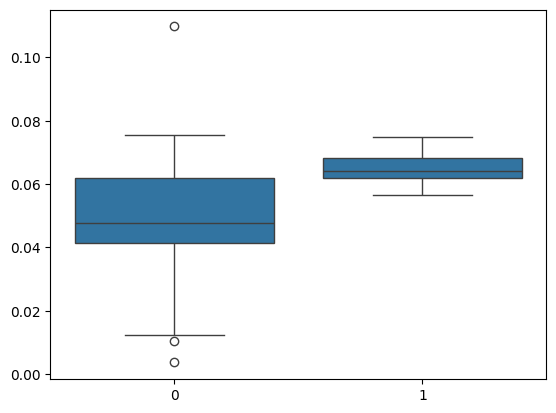

In [28]:
scores = [cohesion_score(test_text, gram_counts) for test_text in testing_data]

sns.boxplot(x=testing_labels, y=scores)